In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Dataset

You can download the dataset from {https://darwin.v7labs.com/v7-labs/covid-19-chest-x-ray-dataset?sort=priority\%3Adesc}.
The data entitled as '`darwin dataset pull v7-labs/covid-19-chest-x-ray-dataset:all-images`' will be used in this assignment. All dataset consist of 6504 images from 702 classes. We will extract the images of 4 classes (Bacterial Pneumonia, Viral Pneumonia, No Pneumonia (healthy), Covid-19) and save them as .npy file with the following code:

In [ ]:
#!pip install scikit-plot

# importing modules
import json
import numpy as np
import pandas as pd
import glob
import urllib.request
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from collections import Counter
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.applications.vgg16 import VGG16
from keras import layers, models


In [ ]:

import json
import numpy as np
import glob
import pandas as pd

# importing modules
import urllib.request
from PIL import Image
from keras import layers, models
import tensorflow as tf

# all-images file should be uploaded to the same file
imageNames = glob.glob("/content/drive/MyDrive/all-images/*")

dataset = []
labels = []

for i, imName in enumerate(imageNames):

    # Opening JSON file
    f = open(imName)
    data = json.load(f)
    for j in range(len(data['annotations'])):

        if 'COVID-19' in (data['annotations'][j]['name']):
          #load images from url    
            urllib.request.urlretrieve(data['image']['url'],"img.png")    
            img = Image.open("img.png")
            #convert images to grayscale
            imgGray = img.convert('L')
            #resize the image (156x156)
            im = imgGray.resize((156,156), Image.LANCZOS)           
            label = data['annotations'][j]['name']
            dataset.append(np.array(im))
            labels.append(label)
            print(label)
            break

        if 'Viral Pneumonia' in (data['annotations'][j]['name']) \
            or 'Bacterial Pneumonia' in (data['annotations'][j]['name']) \
            or 'No Pneumonia (healthy)' in (data['annotations'][j]['name']):
            #load images from url    
            urllib.request.urlretrieve(data['image']['url'],"img.png")    
            img = Image.open("img.png")
            #convert images to grayscale
            imgGray = img.convert('L')
            #resize the image (156x156)
            im = imgGray.resize((156,156), Image.LANCZOS)           
            label = data['annotations'][j]['name']
            dataset.append(np.array(im))
            labels.append(label)
            break

#Convert data shape of (n_of_samples, width, height, 1)
dataset = np.dstack(dataset)    
dataset = np.rollaxis(dataset,-1)
labels = np.array(labels)

#convert images gray scale to rgb
data = np.array(layers.Lambda(tf.image.grayscale_to_rgb)(tf.expand_dims(dataset, -1)))

# save data and labels into a folder
np.save("/content/drive/MyDrive/data_Updated.npy", data)  
np.save("/content/drive/MyDrive/labels_Updated.npy", labels)


Once you save your data, you can load it from your directory.

In [ ]:
import numpy as np

data = np.load('/content/drive/MyDrive/data_Updated.npy')
labels = np.load('/content/drive/MyDrive/labels_Updated.npy')

# Preprocessing Steps



In [ ]:
le =  LabelEncoder() 
label_vector = le.fit_transform(labels)
y = to_categorical(label_vector)

In [ ]:
print(data.shape)
print(labels.shape)

(6405, 156, 156, 3)
(6405,)


In [ ]:
num_classes=len(np.unique(labels))
print(f'num of classes = {num_classes}')
print(np.unique(labels))
Counter(labels)

num of classes = 4
['Bacterial Pneumonia' 'COVID-19' 'No Pneumonia (healthy)'
 'Viral Pneumonia']


Counter({'No Pneumonia (healthy)': 1610,
         'Bacterial Pneumonia': 2822,
         'Viral Pneumonia': 1846,
         'COVID-19': 127})

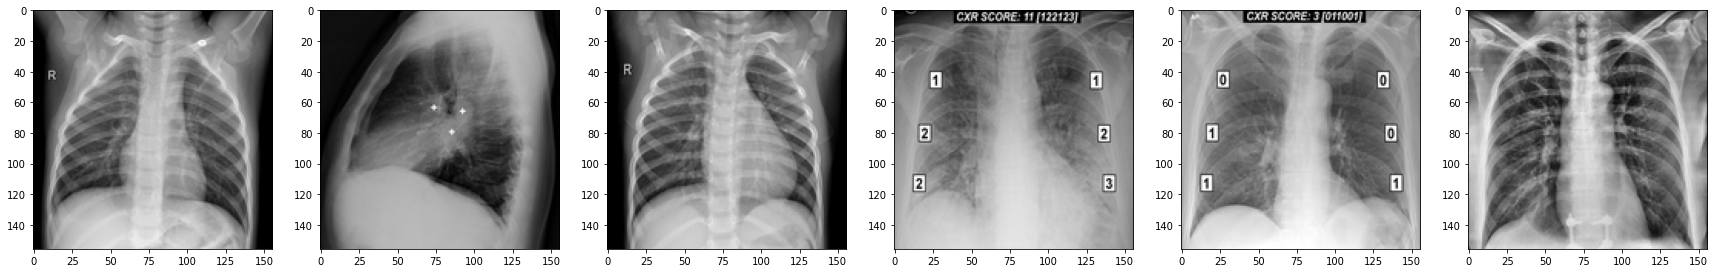

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30))
# plot first few images
for i in range(6):
	# define subplot
	plt.subplot(160 + 1 + i)
	# plot raw pixel data
	plt.imshow(data[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [ ]:
# encode the labels into integer in order to do one-hot encoding
print('four labels become vector:', np.unique(label_vector))
#convert labels into 4 categories with one hot coding
# Convert a class vector (integers) to binary class matrix.
# let y = all the one-hot encoded labels
y = to_categorical(label_vector)
print('the first a few encoded labels:','\n', y[:6])

four labels become vector: [0 1 2 3]
the first a few encoded labels: 
 [[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


## Splitting Data

In [ ]:
# Training set (60%), Validation set (20%), Test set (20%)
# stratify keeps the same percentages of classes in each split.  
X_trainval, X_test, y_trainval, y_test = train_test_split(data, y, test_size = 0.2, stratify=y, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.25, stratify=y_trainval, random_state = 42) 

print(' training set shape:  ', X_train.shape, '\n', 'validation set shape:', X_val.shape, '\n','test set shape:      ', X_test.shape)

 training set shape:   (3843, 156, 156, 3) 
 validation set shape: (1281, 156, 156, 3) 
 test set shape:       (1281, 156, 156, 3)


## Normalize Data

In [ ]:
# convert from integers to floats  
X_train_f = X_train.astype('float32')
X_val_f = X_val.astype('float32')
X_test_f = X_test.astype('float32')


# normalize to range 0-1
X_train_n = X_train_f/ 255.0
X_val_n = X_val_f / 255.0
X_test_n = X_test_f / 255.0


# Create Baseline Model

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

# Create a sequential model
model = Sequential()

# Add convolutional and pooling layers
model.add(layers.Conv2D(64, (3, 3), activation='relu',  padding='same', input_shape = X_train_n.shape[1:])) 
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same')) 
model.add(layers.MaxPooling2D((2, 2)))                      
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))    
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))  
model.add(layers.MaxPooling2D((2, 2)))
# Add a Flatten layer to the model
model.add(layers.Flatten())
# Add a Dense layer with 32 units and relu activation
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
# Add the last Dense layer.
model.add(layers.Dense(4, activation='softmax'))

# Analyze the performance of the baseline model

Epoch 1/20
121/121 [==============================] - 5s 19ms/step - loss: 1.0018 - accuracy: 0.5425 - val_loss: 0.7586 - val_accuracy: 0.7018
Epoch 2/20
121/121 [==============================] - 2s 15ms/step - loss: 0.6971 - accuracy: 0.7138 - val_loss: 0.6166 - val_accuracy: 0.7494
Epoch 3/20
121/121 [==============================] - 2s 15ms/step - loss: 0.6175 - accuracy: 0.7450 - val_loss: 0.5898 - val_accuracy: 0.7650
Epoch 4/20
121/121 [==============================] - 2s 15ms/step - loss: 0.5400 - accuracy: 0.7793 - val_loss: 0.6499 - val_accuracy: 0.7260
Epoch 5/20
121/121 [==============================] - 2s 15ms/step - loss: 0.5034 - accuracy: 0.7890 - val_loss: 0.5944 - val_accuracy: 0.7744
Epoch 6/20
121/121 [==============================] - 2s 15ms/step - loss: 0.4748 - accuracy: 0.8028 - val_loss: 0.5694 - val_accuracy: 0.7721
Epoch 7/20
121/121 [==============================] - 2s 15ms/step - loss: 0.4340 - accuracy: 0.8165 - val_loss: 0.6711 - val_accuracy: 0.7369

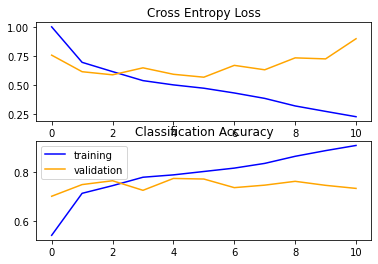

In [ ]:
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train_n, y_train, epochs=20, batch_size=32, validation_data=(X_val_n, y_val), callbacks=[early_stop])
test_loss, test_acc = model.evaluate(X_val_n, y_val)


# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	plt.legend(['training', 'validation'])
	plt.show()
 
summarize_diagnostics(history)

ROC | Baseline Model

41/41 [==============================] - 0s 6ms/step


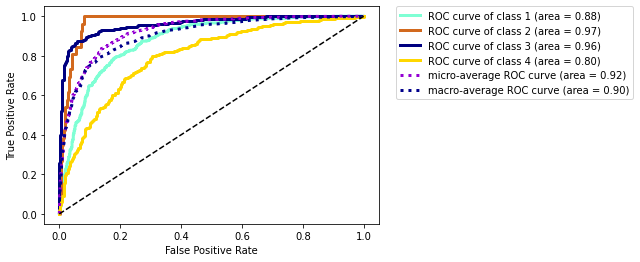

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from itertools import cycle
# Correct ROC graph
#%matplotlib inline

# Make predictions on validation data
y_pred = model.predict(X_val_n)
y_true = np.argmax(y_val, axis=1)

# Compute ROC curve and ROC area for each class
fp_rates = {}
tp_rates = {}
roc_auc = {}
for i in range(4):
    fp_rates[i], tp_rates[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fp_rates[i], tp_rates[i])

# Compute micro-average ROC curve and ROC area
fp_rates["micro"], tp_rates["micro"], _ = roc_curve(y_val.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fp_rates["micro"], tp_rates["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fp_rates[i] for i in range(4)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += np.interp(all_fpr, fp_rates[i], tp_rates[i])
mean_tpr /= 4
fp_rates["macro"] = all_fpr
tp_rates["macro"] = mean_tpr
roc_auc["macro"] = auc(fp_rates["macro"], tp_rates["macro"])

# Plot ROC curves
plt.figure()
colors = cycle(["aquamarine", "chocolate", "navy", "gold"])
for i, color in zip(range(4), colors):
    plt.plot(
        fp_rates[i],
        tp_rates[i],
        color=color,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i+1, roc_auc[i]),
        linewidth=3
    )

plt.plot(
    fp_rates["micro"],
    tp_rates["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="darkviolet",
    linewidth=3,
    linestyle=":"
)

plt.plot(
    fp_rates["macro"],
    tp_rates["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="darkblue",
    linewidth=3,
    linestyle=":"
)

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.legend(loc="lower right")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


Confusion Matrix | Baseline

41/41 [==============================] - 0s 5ms/step


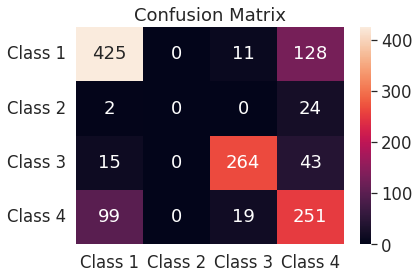

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
### correct confusion matrix

# Make predictions on validation data
y_pred = model.predict(X_val_n)
y_pred = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels to categorical labels
y_true = np.argmax(y_val, axis=1)

# Create confusion matrix
C_M = confusion_matrix(y_true, y_pred)

# Define labels
labels = {0: "Class 1", 1: "Class 2", 2: "Class 3", 3: "Class 4"}

# Plot confusion matrix
sns.set(font_scale=1.5)
ax = sns.heatmap(C_M, annot=True, fmt="d", xticklabels=labels.values(), yticklabels=labels.values())
ax.set_title("Confusion Matrix")
plt.show()

Confusion Matrix | Baseline _Normal

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


y_pred = model.predict(X_val_n)
y_pred = (y_pred > 0.5)

cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)
acc = accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print('test_accuracy: %.3f' % (acc))
print(classification_report(y_val, y_pred, zero_division=1))

41/41 [==============================] - 0s 6ms/step
[[426   0  11 127]
 [  5   0   0  21]
 [ 19   0 262  41]
 [107   0  18 244]]
test_accuracy: 0.728
              precision    recall  f1-score   support

           0       0.79      0.75      0.77       564
           1       1.00      0.00      0.00        26
           2       0.90      0.81      0.85       322
           3       0.56      0.66      0.61       369

   micro avg       0.74      0.73      0.73      1281
   macro avg       0.81      0.56      0.56      1281
weighted avg       0.76      0.73      0.73      1281
 samples avg       0.74      0.73      0.73      1281



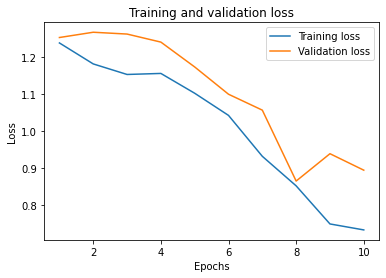

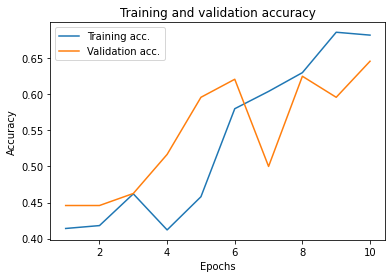

In [ ]:
history_dict = original_hist.history
#%matplotlib inline

def plot_history(data_list, label_list, title, ylabel):
    epochs = range(1, len(data_list[0]) + 1)

    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data, label=label)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()


acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss')
plot_history(data_list=[acc, val_acc],
             label_list=['Training acc.', 'Validation acc.'],
             title='Training and validation accuracy',
             ylabel='Accuracy')

# Adapting/fine-tuning the network

In [ ]:
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)



def build_model(nb_units=32):
    
    model = models.Sequential()
    model.add(layers.Conv2D(nb_units, (3, 3), activation='relu', padding='same', input_shape = X_train_n.shape[1:])) 
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(nb_units, (3, 3), padding='same', activation='relu'))  
    model.add(layers.MaxPooling2D((2, 2)))    
    model.add(layers.Dropout(0.5))  
    model.add(layers.Conv2D(nb_units, (3, 3), activation='relu'))  
    model.add(layers.MaxPooling2D((2, 2)))    
    model.add(layers.Conv2D(nb_units, (3, 3), activation='relu'))  
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))    
    model.add(layers.Flatten())                     
    model.add(layers.Dense(nb_units, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model


partial_x_val = X_val_n[:240]
partial_x_train = X_train_n[:500]

partial_y_val = y_val[:240]
partial_y_train = y_train[:500]

model1 = build_model()   ## units 32
original_hist = model1.fit(X_train_n,
                          y_train,
                          epochs=20,
                          batch_size=40,
                          validation_data=(X_val_n, y_val),
                          verbose=1,
                          callbacks=[early_stop])

Epoch 1/20
13/13 [==============================] - 3s 36ms/step - loss: 1.2312 - accuracy: 0.3320 - val_loss: 1.1971 - val_accuracy: 0.2708
Epoch 2/20
13/13 [==============================] - 0s 16ms/step - loss: 1.1792 - accuracy: 0.3960 - val_loss: 1.1613 - val_accuracy: 0.4458
Epoch 3/20
13/13 [==============================] - 0s 15ms/step - loss: 1.1362 - accuracy: 0.4720 - val_loss: 1.1497 - val_accuracy: 0.4458
Epoch 4/20
13/13 [==============================] - 0s 15ms/step - loss: 1.1230 - accuracy: 0.4820 - val_loss: 1.1755 - val_accuracy: 0.5875
Epoch 5/20
13/13 [==============================] - 0s 15ms/step - loss: 1.0697 - accuracy: 0.5100 - val_loss: 1.1498 - val_accuracy: 0.4083
Epoch 6/20
13/13 [==============================] - 0s 15ms/step - loss: 1.0546 - accuracy: 0.5400 - val_loss: 1.1159 - val_accuracy: 0.6000
Epoch 7/20
13/13 [==============================] - 0s 15ms/step - loss: 0.9040 - accuracy: 0.6200 - val_loss: 0.9212 - val_accuracy: 0.6250
Epoch 8/20
13

Confusion Matrix | Our Finetuned Model

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


y_pred = model.predict(X_val_n)
y_pred = (y_pred > 0.5)

cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)
acc = accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print('test_accuracy: %.3f' % (acc))
print(classification_report(y_val, y_pred, zero_division=1))

ROC curve | Our Finetuned Model

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
### correct confusion matrix

# Make predictions on validation data
y_pred = model.predict(X_val_n)
y_pred = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels to categorical labels
y_true = np.argmax(y_val, axis=1)

# Create confusion matrix
C_M = confusion_matrix(y_true, y_pred)

# Define labels
labels = {0: "Class 1", 1: "Class 2", 2: "Class 3", 3: "Class 4"}

# Plot confusion matrix
sns.set(font_scale=1.5)
ax = sns.heatmap(C_M, annot=True, fmt="d", xticklabels=labels.values(), yticklabels=labels.values())
ax.set_title("Confusion Matrix")
plt.show()

L2 Regularized

In [ ]:
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


from tensorflow.keras import regularizers
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
# What is modified in this version
# 
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from sklearn.utils import class_weight
from tensorflow.keras import backend as K


"""
partial_x_val = X_val_n[:240]
partial_x_train = X_train_n[:500]

partial_y_val = y_val[:240]
partial_y_train = y_train[:500]
"""

lr = 0.0001
optimizer = Adam(learning_rate=lr)

class_weights = {
    0: 1.0,  # Class 0 has the most samples, so we weight it lower
    1: 8.0,  # Class 1 has the fewest samples, so we weight it higher
    2: 2.0,
    3: 2.0}

data = np.load('/content/drive/MyDrive/data_Updated.npy')
labels = np.load('/content/drive/MyDrive/labels_Updated.npy')

le =  LabelEncoder() 
label_vector = le.fit_transform(labels)
y = to_categorical(label_vector)

X_trainval, X_test, y_trainval, y_test = train_test_split(data, y, test_size = 0.2, stratify=y, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.25, stratify=y_trainval, random_state = 42) 

# convert from integers to floats  
X_train_f = X_train.astype('float32')
X_val_f = X_val.astype('float32')
X_test_f = X_test.astype('float32')


# normalize to range 0-1
X_train_n = X_train_f/ 255.0
X_val_n = X_val_f / 255.0
X_test_n = X_test_f / 255.0




# data agumentation 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(156, 156,3)),
    layers.experimental.preprocessing.RandomRotation(0.15),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)




def build_regularized_model( regularizer=regularizers.l2(0.001)):
    model = models.Sequential()
    model.add(data_augmentation)
    model.add(layers.Conv2D(16,(3, 3), activation='relu', padding='same', input_shape = X_train_n.shape[1:])) 
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizer, padding='same', activation='relu'))  
    model.add(layers.MaxPooling2D((2, 2)))    
    model.add(layers.Dropout(0.5))  
    model.add(layers.Conv2D(8, (3, 3), kernel_regularizer=regularizer, activation='relu'))  
    model.add(layers.MaxPooling2D((2, 2)))    
    model.add(layers.Conv2D(8, (3, 3), activation='relu'))  
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))    
    model.add(layers.Flatten())                     
    model.add(layers.Dense(8, kernel_regularizer=regularizer,activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))
    model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

 
l2_model = build_regularized_model()
l2_model_hist = l2_model.fit(X_train_n, y_train, epochs=40, batch_size=10, validation_data=(X_val_n, y_val), verbose=1,class_weight=class_weights,
                          callbacks=[early_stop])
 

# L1 regularization
regularizers.l1(0.001)
regularizers.l1_l2(l1=0.001, l2=0.001)



def l2_reg(weight_matrix, lmbd):
    return lmbd * K.sum(K.square(weight_matrix))
 
    
l2_custom_model = build_regularized_model(regularizer=(lambda w: l2_reg(w, 0.001)))
l2_custom_model_hist = l2_custom_model.fit(X_train_n, y_train, epochs=40, batch_size=10, validation_data=(X_val_n, y_val), verbose=1,class_weight=class_weights,
                          callbacks=[early_stop])

Epoch 1/40


385/385 [==============================] - 23s 48ms/step - loss: 2.2868 - accuracy: 0.2706 - val_loss: 1.3718 - val_accuracy: 0.2904
Epoch 2/40
385/385 [==============================] - 18s 46ms/step - loss: 2.2258 - accuracy: 0.3021 - val_loss: 1.3540 - val_accuracy: 0.2857
Epoch 3/40
385/385 [==============================] - 18s 47ms/step - loss: 2.2143 - accuracy: 0.2990 - val_loss: 1.3324 - val_accuracy: 0.3302
Epoch 4/40
385/385 [==============================] - 18s 47ms/step - loss: 2.1980 - accuracy: 0.3130 - val_loss: 1.3478 - val_accuracy: 0.2920
Epoch 5/40
385/385 [==============================] - 19s 49ms/step - loss: 2.1706 - accuracy: 0.3365 - val_loss: 1.2913 - val_accuracy: 0.3833
Epoch 6/40
385/385 [==============================] - 20s 51ms/step - loss: 2.1209 - accuracy: 0.3638 - val_loss: 1.2491 - val_accuracy: 0.3653
Epoch 7/40
385/385 [==============================] - 20s 53ms/step - loss: 2.0692 - accuracy: 0.3869 - val_loss: 1.2014 - val_accuracy: 0.4114
Epo

Epoch 1/40


385/385 [==============================] - 22s 47ms/step - loss: 2.2658 - accuracy: 0.3380 - val_loss: 1.3108 - val_accuracy: 0.3021
Epoch 2/40
385/385 [==============================] - 18s 46ms/step - loss: 2.2167 - accuracy: 0.3328 - val_loss: 1.3390 - val_accuracy: 0.2881
Epoch 3/40
385/385 [==============================] - 17s 45ms/step - loss: 2.2069 - accuracy: 0.2894 - val_loss: 1.3115 - val_accuracy: 0.2896
Epoch 4/40
385/385 [==============================] - 18s 47ms/step - loss: 2.1870 - accuracy: 0.3018 - val_loss: 1.2925 - val_accuracy: 0.2927
Epoch 5/40
385/385 [==============================] - 18s 48ms/step - loss: 2.1781 - accuracy: 0.3016 - val_loss: 1.2982 - val_accuracy: 0.2865
Epoch 6/40
385/385 [==============================] - 19s 48ms/step - loss: 2.1672 - accuracy: 0.3052 - val_loss: 1.2968 - val_accuracy: 0.3318
Epoch 7/40
385/385 [==============================] - 18s 48ms/step - loss: 2.1417 - accuracy: 0.3232 - val_loss: 1.2712 - val_accuracy: 0.3747
Epo

41/41 [==============================] - 1s 18ms/step


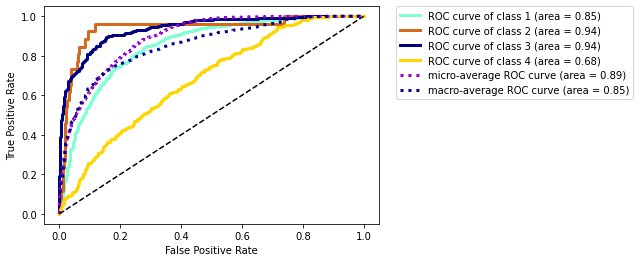

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from itertools import cycle
# Correct ROC graph
#%matplotlib inline

   
#l2_custom_model = build_regularized_model(regularizer=(lambda w: l2_reg(w, 0.001)))
#l2_custom_model_hist = l2_custom_model.fit(X_train_n, y_train, epochs=40, batch_size=10, validation_data=(X_val_n, y_val), verbose=1,class_weight=class_weights,
#                          callbacks=[early_stop])

# Make predictions on validation data
y_pred = l2_custom_model.predict(X_val_n)
y_true = np.argmax(y_val, axis=1)

# Compute ROC curve and ROC area for each class
fp_rates = {}
tp_rates = {}
roc_auc = {}
for i in range(4):
    fp_rates[i], tp_rates[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fp_rates[i], tp_rates[i])

# Compute micro-average ROC curve and ROC area
fp_rates["micro"], tp_rates["micro"], _ = roc_curve(y_val.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fp_rates["micro"], tp_rates["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fp_rates[i] for i in range(4)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += np.interp(all_fpr, fp_rates[i], tp_rates[i])
mean_tpr /= 4
fp_rates["macro"] = all_fpr
tp_rates["macro"] = mean_tpr
roc_auc["macro"] = auc(fp_rates["macro"], tp_rates["macro"])

# Plot ROC curves
plt.figure()
colors = cycle(["aquamarine", "chocolate", "navy", "gold"])
for i, color in zip(range(4), colors):
    plt.plot(
        fp_rates[i],
        tp_rates[i],
        color=color,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i+1, roc_auc[i]),
        linewidth=3
    )

plt.plot(
    fp_rates["micro"],
    tp_rates["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="darkviolet",
    linewidth=3,
    linestyle=":"
)

plt.plot(
    fp_rates["macro"],
    tp_rates["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="darkblue",
    linewidth=3,
    linestyle=":"
)

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.legend(loc="lower right")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


y_pred = l2_custom_model.predict(X_val_n)
y_pred = (y_pred > 0.5)

cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)
acc = accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print('test_accuracy: %.3f' % (acc))
print(classification_report(y_val, y_pred, zero_division=1))

41/41 [==============================] - 1s 18ms/step
[[518   0  15  31]
 [  7  15   1   3]
 [ 93   1 223   5]
 [268  41  22  38]]
test_accuracy: 0.620
              precision    recall  f1-score   support

           0       0.78      0.67      0.72       564
           1       0.26      0.58      0.36        26
           2       0.85      0.69      0.77       322
           3       0.49      0.10      0.17       369

   micro avg       0.74      0.51      0.61      1281
   macro avg       0.60      0.51      0.50      1281
weighted avg       0.70      0.51      0.57      1281
 samples avg       0.82      0.51      0.51      1281



l2_custom_model | Confusion Matrix

41/41 [==============================] - 1s 16ms/step


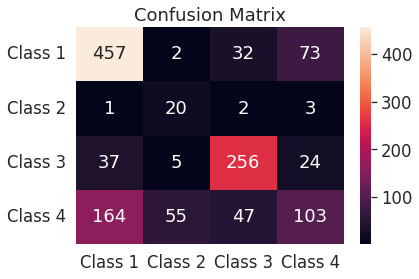

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
### correct confusion matrix

# Make predictions on validation data
y_pred = l2_custom_model.predict(X_val_n)
y_pred = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels to categorical labels
y_true = np.argmax(y_val, axis=1)

# Create confusion matrix
C_M = confusion_matrix(y_true, y_pred)

# Define labels
labels = {0: "Class 1", 1: "Class 2", 2: "Class 3", 3: "Class 4"}

# Plot confusion matrix
sns.set(font_scale=1.5)
ax = sns.heatmap(C_M, annot=True, fmt="d", xticklabels=labels.values(), yticklabels=labels.values())
ax.set_title("Confusion Matrix")
plt.show()

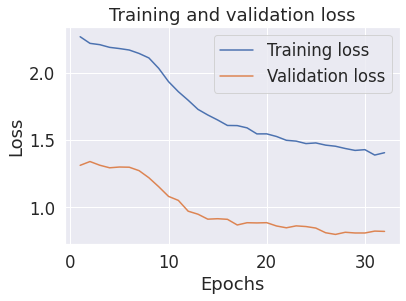

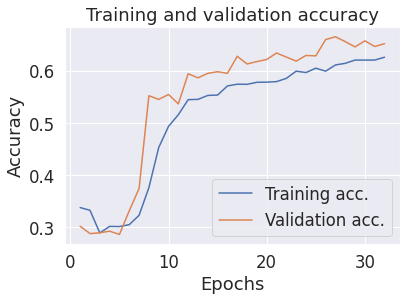

In [ ]:
history_dict = l2_custom_model_hist.history
#%matplotlib inline
#l2_custom_model_hist

def plot_history(data_list, label_list, title, ylabel):
    epochs = range(1, len(data_list[0]) + 1)

    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data, label=label)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()


acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss')
plot_history(data_list=[acc, val_acc],
             label_list=['Training acc.', 'Validation acc.'],
             title='Training and validation accuracy',
             ylabel='Accuracy')

In [ ]:
smaller_model = build_model(nb_units=8)
smaller_model_hist = smaller_model.fit(partial_x_train, partial_y_train,
                                       epochs=20,
                                       batch_size=1,
                                       validation_data=(partial_x_val, partial_y_val),
                                       verbose=1)
mid_model = build_model(nb_units=16)
mid_model_hist = mid_model.fit(partial_x_train, partial_y_train,
                                     epochs=20,
                                     batch_size=1,
                                     validation_data=(partial_x_val, partial_y_val),
                                     verbose=1)


Epoch 1/20
500/500 [==============================] - 5s 6ms/step - loss: 1.2118 - accuracy: 0.3940 - val_loss: 1.2807 - val_accuracy: 0.4458
Epoch 2/20
500/500 [==============================] - 3s 5ms/step - loss: 1.1776 - accuracy: 0.4340 - val_loss: 1.2803 - val_accuracy: 0.4458
Epoch 3/20
500/500 [==============================] - 3s 5ms/step - loss: 1.1586 - accuracy: 0.4340 - val_loss: 1.2393 - val_accuracy: 0.4458
Epoch 4/20
500/500 [==============================] - 3s 5ms/step - loss: 1.1610 - accuracy: 0.4340 - val_loss: 1.2113 - val_accuracy: 0.4458
Epoch 5/20
500/500 [==============================] - 3s 6ms/step - loss: 1.1485 - accuracy: 0.4320 - val_loss: 1.2311 - val_accuracy: 0.4458
Epoch 6/20
500/500 [==============================] - 3s 6ms/step - loss: 1.1110 - accuracy: 0.4580 - val_loss: 1.1740 - val_accuracy: 0.5125
Epoch 7/20
500/500 [==============================] - 3s 5ms/step - loss: 1.1233 - accuracy: 0.4620 - val_loss: 1.1161 - val_accuracy: 0.4458
Epoch 

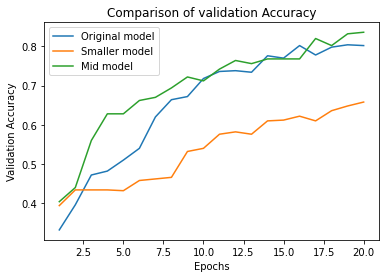

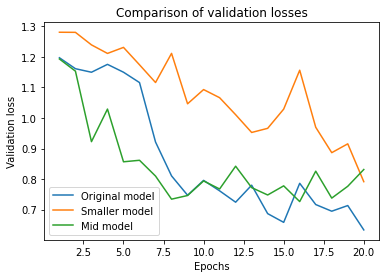

In [ ]:
original_val_loss = original_hist.history['val_loss']
original_val_acc = original_hist.history['accuracy'] 

smaller_model_val_loss = smaller_model_hist.history['val_loss']
smaller_model_val_acc = smaller_model_hist.history['accuracy'] 

mid_model_val_loss = mid_model_hist.history['val_loss']
mid_model_val_acc = mid_model_hist.history['accuracy'] 

#Accuracy

plot_history(data_list=[original_val_acc, smaller_model_val_acc, mid_model_val_acc],
             label_list=['Original model', 'Smaller model', 'Mid model'],
             title='Comparison of validation Accuracy',
             ylabel='Validation Accuracy')


#Loss
plot_history(data_list=[original_val_loss, smaller_model_val_loss, mid_model_val_loss],
             label_list=['Original model', 'Smaller model', 'Mid model'],
             title='Comparison of validation losses',
             ylabel='Validation loss')



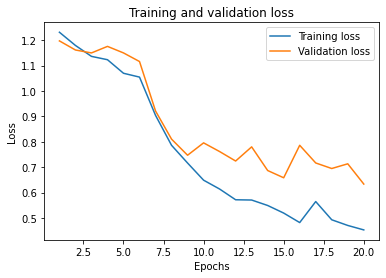

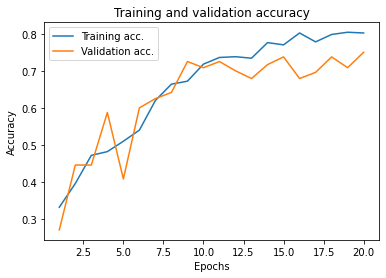

In [ ]:
history_dict = original_hist.history
#%matplotlib inline
import matplotlib.pyplot as plt


def plot_history(data_list, label_list, title, ylabel):
    epochs = range(1, len(data_list[0]) + 1)

    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data, label=label)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()


acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss')
plot_history(data_list=[acc, val_acc],
             label_list=['Training acc.', 'Validation acc.'],
             title='Training and validation accuracy',
             ylabel='Accuracy')

Validation + Test

In [ ]:
le =  LabelEncoder() 
label_vector = le.fit_transform(labels)
y = to_categorical(label_vector)
X_trainval, X_test, y_trainval, y_test = train_test_split(data, y, test_size = 0.2, stratify=y, random_state = 42)
X_trainval_f = X_trainval.astype('float32')
X_test_f = X_test.astype('float32')

X_train_total = X_trainval_f/ 255.0
X_test = X_test_f/ 255.0
#nb_units= 8
nb_units= 32

model = Sequential()
# Add convolutional and pooling layers
model.add(layers.Conv2D(nb_units, (3, 3), activation='relu', padding='same', input_shape = X_train_total.shape[1:])) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(nb_units, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))    
model.add(layers.Dropout(0.5))  
model.add(layers.Conv2D(nb_units, (3, 3), activation='relu'))  
model.add(layers.MaxPooling2D((2, 2)))    
model.add(layers.Conv2D(nb_units, (3, 3), activation='relu'))  
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))    
model.add(layers.Flatten())                     
model.add(layers.Dense(nb_units, activation='relu'))
# Add the last Dense layer.
model.add(layers.Dense(4, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_total, y_trainval, epochs=20, batch_size=1, validation_data=(X_test, y_test))
test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/20
5124/5124 [==============================] - 29s 5ms/step - loss: 0.8745 - accuracy: 0.6142 - val_loss: 0.7272 - val_accuracy: 0.6792
Epoch 2/20
5124/5124 [==============================] - 26s 5ms/step - loss: 0.6636 - accuracy: 0.7264 - val_loss: 0.5898 - val_accuracy: 0.7627
Epoch 3/20
5124/5124 [==============================] - 26s 5ms/step - loss: 0.6196 - accuracy: 0.7480 - val_loss: 0.6247 - val_accuracy: 0.7518
Epoch 4/20
5124/5124 [==============================] - 26s 5ms/step - loss: 0.5888 - accuracy: 0.7600 - val_loss: 0.5713 - val_accuracy: 0.7689
Epoch 5/20
5124/5124 [==============================] - 26s 5ms/step - loss: 0.5774 - accuracy: 0.7644 - val_loss: 0.5492 - val_accuracy: 0.7814
Epoch 6/20
5124/5124 [==============================] - 26s 5ms/step - loss: 0.5603 - accuracy: 0.7703 - val_loss: 0.5252 - val_accuracy: 0.7916
Epoch 7/20
5124/5124 [==============================] - 26s 5ms/step - loss: 0.5442 - accuracy: 0.7748 - val_loss: 0.5450 - val_ac

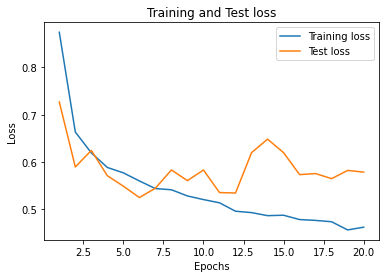

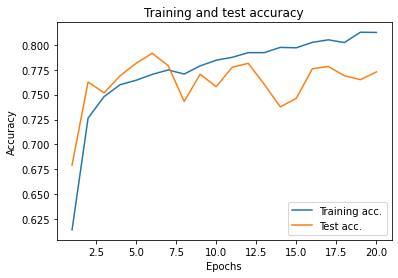

In [ ]:
history_dict = history.history
#%matplotlib inline
import matplotlib.pyplot as plt


def plot_history(data_list, label_list, title, ylabel):
    epochs = range(1, len(data_list[0]) + 1)

    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data, label=label)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()


acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Test loss'],
             title='Training and Test loss',
             ylabel='Loss')
plot_history(data_list=[acc, val_acc],
             label_list=['Training acc.', 'Test acc.'],
             title='Training and test accuracy',
             ylabel='Accuracy')



In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)
acc = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('test_accuracy: %.3f' % (acc))

print(classification_report(y_test, y_pred, zero_division=1))
 

41/41 [==============================] - 0s 4ms/step
[[494   1  13  57]
 [  0   5   0  20]
 [ 17   0 297   8]
 [146  12  21 190]]
test_accuracy: 0.770
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       565
           1       0.28      0.20      0.23        25
           2       0.90      0.92      0.91       322
           3       0.69      0.51      0.59       369

   micro avg       0.79      0.76      0.77      1281
   macro avg       0.66      0.62      0.64      1281
weighted avg       0.78      0.76      0.76      1281
 samples avg       0.80      0.76      0.76      1281



In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)
acc = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('test_accuracy: %.3f' % (acc))

print(classification_report(y_test, y_pred, zero_division=1))
 

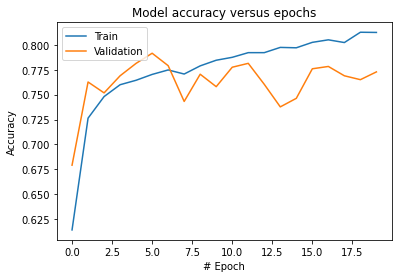

In [ ]:
import matplotlib.pyplot as plot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import seaborn as sns
%matplotlib inline
from itertools import cycle

plot.plot(history.history['accuracy'])
plot.plot(history.history['val_accuracy'])
plot.title('Model accuracy versus epochs')
plot.ylabel('Accuracy')
plot.xlabel('# Epoch')
plot.legend(['Train', 'Validation'], loc= 'upper left')
plot.show()

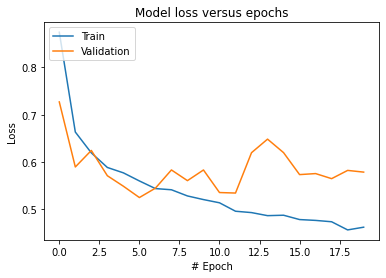

In [ ]:
plot.plot(history.history['loss'])
plot.plot(history.history['val_loss'])
plot.title('Model loss versus epochs')
plot.ylabel('Loss')
plot.xlabel('# Epoch')
plot.legend(['Train', 'Validation'], loc='upper left')
plot.show()

41/41 [==============================] - 0s 5ms/step


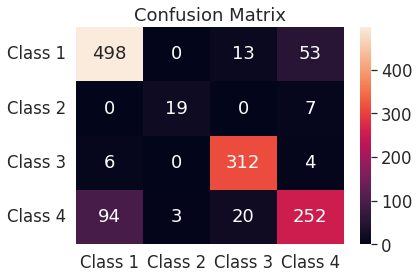

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
### correct confusion matrix

# Make predictions on validation data
y_pred = model.predict(X_val_n)
y_pred = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels to categorical labels
y_true = np.argmax(y_val, axis=1)

# Create confusion matrix
C_M = confusion_matrix(y_true, y_pred)

# Define labels
labels = {0: "Class 1", 1: "Class 2", 2: "Class 3", 3: "Class 4"}

# Plot confusion matrix
sns.set(font_scale=1.5)
ax = sns.heatmap(C_M, annot=True, fmt="d", xticklabels=labels.values(), yticklabels=labels.values())
ax.set_title("Confusion Matrix")
plt.show()

41/41 [==============================] - 0s 3ms/step


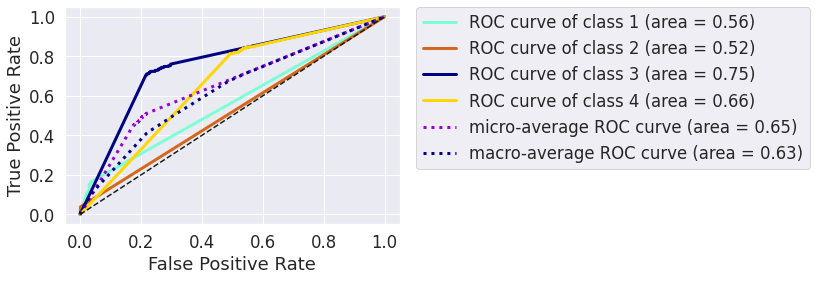

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from itertools import cycle
# Correct ROC graph
#%matplotlib inline

# Make predictions on validation data
y_pred = model.predict(X_val)
y_true = np.argmax(y_val, axis=1)

# Compute ROC curve and ROC area for each class
fp_rates = {}
tp_rates = {}
roc_auc = {}
for i in range(4):
    fp_rates[i], tp_rates[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fp_rates[i], tp_rates[i])

# Compute micro-average ROC curve and ROC area
fp_rates["micro"], tp_rates["micro"], _ = roc_curve(y_val.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fp_rates["micro"], tp_rates["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fp_rates[i] for i in range(4)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += np.interp(all_fpr, fp_rates[i], tp_rates[i])
mean_tpr /= 4
fp_rates["macro"] = all_fpr
tp_rates["macro"] = mean_tpr
roc_auc["macro"] = auc(fp_rates["macro"], tp_rates["macro"])

# Plot ROC curves
plt.figure()
colors = cycle(["aquamarine", "chocolate", "navy", "gold"])
for i, color in zip(range(4), colors):
    plt.plot(
        fp_rates[i],
        tp_rates[i],
        color=color,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i+1, roc_auc[i]),
        linewidth=3
    )

plt.plot(
    fp_rates["micro"],
    tp_rates["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="darkviolet",
    linewidth=3,
    linestyle=":"
)

plt.plot(
    fp_rates["macro"],
    tp_rates["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="darkblue",
    linewidth=3,
    linestyle=":"
)

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.legend(loc="lower right")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


# Transfer Learning

In [ ]:
from tensorflow.keras import layers
from keras.models import Model

vgg_model = VGG16(include_top=False, input_shape = X_train_n.shape[1:])

# mark loaded layers as not trainable
for layer in vgg_model.layers:
	layer.trainable = False
	


# add new classifier layers
#add flatten layer
flat1 = layers.Flatten()(vgg_model.layers[-1].output)
#add Dense layer
class1 = layers.Dense(128, activation='relu')(flat1)
#add output layer with softmax activation
output = layers.Dense(4, activation='softmax')(class1)
# define new model
vgg_model = Model(inputs=vgg_model.inputs, outputs=output)
# summarize
vgg_model.summary()   

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 156, 156, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 156, 156, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 156, 156, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 78, 78, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 78, 78, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 78, 78, 128)       147584    
                                                              

l2_custom_model + VGG | Transfer Learning

In [ ]:
from tensorflow.keras import layers
from keras.models import Model

vgg_model = VGG16(include_top=False, input_shape = X_train_n.shape[1:])

# mark loaded layers as not trainable
for layer in vgg_model.layers:
	layer.trainable = False
	


# add new classifier layers
#add flatten layer
flat1 = layers.Flatten()(vgg_model.layers[-1].output)
#add Dense layer
class1 = layers.Dense(128, activation='relu')(flat1)
#add output layer with softmax activation
output = layers.Dense(4, activation='softmax')(class1)
# define new model
vgg_model = Model(inputs=vgg_model.inputs, outputs=output)
# summarize
vgg_model.summary()   

In [ ]:
# compile model
#Slight increase of 0.02 % post using AdaDelta
vgg_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = vgg_model.fit(X_train_n, y_train, validation_data=(X_val_n, y_val), epochs=20, verbose=1)



Epoch 1/20
121/121 [==============================] - 4s 22ms/step - loss: 0.6507 - accuracy: 0.7426 - val_loss: 0.5900 - val_accuracy: 0.7564
Epoch 2/20
121/121 [==============================] - 2s 17ms/step - loss: 0.4883 - accuracy: 0.7950 - val_loss: 0.5992 - val_accuracy: 0.7471
Epoch 3/20
121/121 [==============================] - 2s 17ms/step - loss: 0.4662 - accuracy: 0.8077 - val_loss: 0.5121 - val_accuracy: 0.8048
Epoch 4/20
121/121 [==============================] - 2s 17ms/step - loss: 0.3984 - accuracy: 0.8381 - val_loss: 0.6005 - val_accuracy: 0.7705
Epoch 5/20
121/121 [==============================] - 2s 17ms/step - loss: 0.3907 - accuracy: 0.8405 - val_loss: 0.5524 - val_accuracy: 0.7884
Epoch 6/20
121/121 [==============================] - 2s 17ms/step - loss: 0.3249 - accuracy: 0.8738 - val_loss: 0.5816 - val_accuracy: 0.7681
Epoch 7/20
121/121 [==============================] - 2s 17ms/step - loss: 0.3076 - accuracy: 0.8772 - val_loss: 0.6485 - val_accuracy: 0.7572

41/41 [==============================] - 1s 11ms/step


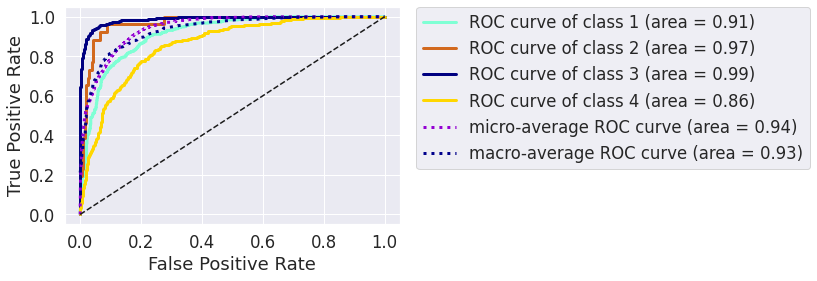

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from itertools import cycle
# Correct ROC graph
#%matplotlib inline

# Make predictions on validation data
y_pred = vgg_model.predict(X_val_n)
y_true = np.argmax(y_val, axis=1)

# Compute ROC curve and ROC area for each class
fp_rates = {}
tp_rates = {}
roc_auc = {}
for i in range(4):
    fp_rates[i], tp_rates[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fp_rates[i], tp_rates[i])

# Compute micro-average ROC curve and ROC area
fp_rates["micro"], tp_rates["micro"], _ = roc_curve(y_val.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fp_rates["micro"], tp_rates["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fp_rates[i] for i in range(4)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += np.interp(all_fpr, fp_rates[i], tp_rates[i])
mean_tpr /= 4
fp_rates["macro"] = all_fpr
tp_rates["macro"] = mean_tpr
roc_auc["macro"] = auc(fp_rates["macro"], tp_rates["macro"])

# Plot ROC curves
plt.figure()
colors = cycle(["aquamarine", "chocolate", "navy", "gold"])
for i, color in zip(range(4), colors):
    plt.plot(
        fp_rates[i],
        tp_rates[i],
        color=color,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i+1, roc_auc[i]),
        linewidth=3
    )

plt.plot(
    fp_rates["micro"],
    tp_rates["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="darkviolet",
    linewidth=3,
    linestyle=":"
)

plt.plot(
    fp_rates["macro"],
    tp_rates["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="darkblue",
    linewidth=3,
    linestyle=":"
)

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.legend(loc="lower right")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report



y_pred = vgg_model.predict(X_val_n)
y_pred = (y_pred > 0.5)

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)
acc = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('test_accuracy: %.3f' % (acc))

print(classification_report(y_test, y_pred, zero_division=1))
 

41/41 [==============================] - 0s 11ms/step
[[359   4 121  81]
 [ 13   1   9   2]
 [195   5  81  41]
 [224   5  93  47]]
test_accuracy: 0.381
              precision    recall  f1-score   support

           0       0.45      0.62      0.53       565
           1       0.07      0.04      0.05        25
           2       0.27      0.25      0.26       322
           3       0.27      0.13      0.17       369

   micro avg       0.38      0.38      0.38      1281
   macro avg       0.27      0.26      0.25      1281
weighted avg       0.35      0.38      0.35      1281
 samples avg       0.39      0.38      0.38      1281



41/41 [==============================] - 0s 11ms/step


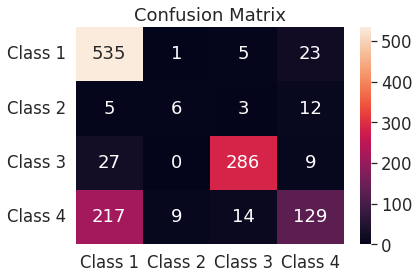

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
### correct confusion matrix

# Make predictions on validation data
y_pred = vgg_model.predict(X_val_n)
y_pred = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels to categorical labels
y_true = np.argmax(y_val, axis=1)

# Create confusion matrix
C_M = confusion_matrix(y_true, y_pred)

# Define labels
labels = {0: "Class 1", 1: "Class 2", 2: "Class 3", 3: "Class 4"}

# Plot confusion matrix
sns.set(font_scale=1.5)
ax = sns.heatmap(C_M, annot=True, fmt="d", xticklabels=labels.values(), yticklabels=labels.values())
ax.set_title("Confusion Matrix")
plt.show()

In [ ]:
############tunning + dropout layer #########

#  version15
import numpy as np
import pandas as pd
import glob
#%matplotlib inline
import matplotlib.pyplot as plt
 
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K


import matplotlib.pyplot as plt


def plot_history(data_list, label_list, title, ylabel):
    epochs = range(1, len(data_list[0]) + 1)

    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data, label=label)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()

 
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

import numpy as np
import glob
import pandas as pd
import numpy as np


#################################################################
from keras.optimizers import Adam
# Set the learning rate
lr = 0.001
optimizer = Adam(learning_rate=lr)


def build_model(nb_units=8):
    
    model = models.Sequential()
    model.add(layers.Conv2D(nb_units, (3, 3), activation='relu', padding='same', input_shape = X_train_n.shape[1:])) 
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(nb_units, (3, 3), padding='same', activation='relu'))  
    model.add(layers.MaxPooling2D((2, 2)))    
    model.add(layers.Dropout(0.5))  
    model.add(layers.Conv2D(nb_units, (3, 3), activation='relu'))  
    model.add(layers.MaxPooling2D((2, 2)))    
    model.add(layers.Conv2D(nb_units, (3, 3), activation='relu'))  
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))    
    model.add(layers.Flatten())                     
    model.add(layers.Dense(nb_units, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model


orig_model = build_model()
orig_model_hist = orig_model.fit(partial_x_train, partial_y_train, epochs=40, batch_size=10, validation_data=(partial_x_val, partial_y_val), verbose=1)



def build_regularized_model( regularizer=regularizers.l2(0.001)):
    model = models.Sequential()
    model.add(layers.Conv2D(16,(3, 3), activation='relu', padding='same', input_shape = X_train_n.shape[1:])) 
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizer, padding='same', activation='relu'))  
    model.add(layers.MaxPooling2D((2, 2)))    
    model.add(layers.Dropout(0.5))  
    model.add(layers.Conv2D(8, (3, 3), kernel_regularizer=regularizer, activation='relu'))  
    model.add(layers.MaxPooling2D((2, 2)))    
    model.add(layers.Conv2D(8, (3, 3), activation='relu'))  
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))    
    model.add(layers.Flatten())                     
    model.add(layers.Dense(8, kernel_regularizer=regularizer,activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))
    model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

 
l2_model = build_regularized_model()
l2_model_hist = l2_model.fit(partial_x_train, partial_y_train, epochs=40, batch_size=10, validation_data=(partial_x_val, partial_y_val), verbose=1)
 

# L1 regularization
regularizers.l1(0.001)
regularizers.l1_l2(l1=0.001, l2=0.001)



def l2_reg(weight_matrix, lmbd):
    return lmbd * K.sum(K.square(weight_matrix))
 
    
l2_custom_model = build_regularized_model(regularizer=(lambda w: l2_reg(w, 0.001)))
l2_custom_model_hist = l2_custom_model.fit(partial_x_train, partial_y_train, epochs=40, batch_size=10, validation_data=(partial_x_val, partial_y_val), verbose=1)

Epoch 1/40
50/50 [==============================] - 3s 12ms/step - loss: 1.2215 - accuracy: 0.3900 - val_loss: 1.1951 - val_accuracy: 0.4458
Epoch 2/40
50/50 [==============================] - 0s 7ms/step - loss: 1.1694 - accuracy: 0.4060 - val_loss: 1.1622 - val_accuracy: 0.4542
Epoch 3/40
50/50 [==============================] - 0s 7ms/step - loss: 1.1548 - accuracy: 0.4440 - val_loss: 1.1859 - val_accuracy: 0.5000
Epoch 4/40
50/50 [==============================] - 0s 7ms/step - loss: 1.1385 - accuracy: 0.4200 - val_loss: 1.1965 - val_accuracy: 0.5708
Epoch 5/40
50/50 [==============================] - 0s 7ms/step - loss: 1.1234 - accuracy: 0.4940 - val_loss: 1.1780 - val_accuracy: 0.6208
Epoch 6/40
50/50 [==============================] - 0s 7ms/step - loss: 1.0544 - accuracy: 0.5140 - val_loss: 1.0346 - val_accuracy: 0.5708
Epoch 7/40
50/50 [==============================] - 0s 7ms/step - loss: 0.9794 - accuracy: 0.5760 - val_loss: 0.9912 - val_accuracy: 0.6500
Epoch 8/40
50/50 [=

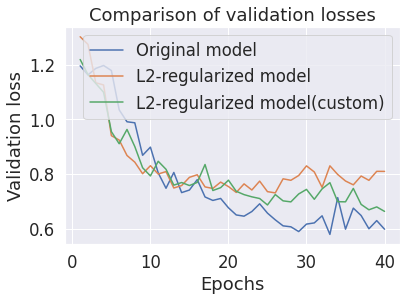

In [ ]:
history_dict1 = orig_model_hist.history
history_dic2 = l2_model_hist.history
history_dict3 = l2_custom_model_hist.history


original_val_loss = history_dict1['val_loss']
l2_model_val_loss = history_dic2['val_loss']
l2_custom_model_val_loss = history_dict3['val_loss']

plot_history(data_list=[original_val_loss, l2_model_val_loss, l2_custom_model_val_loss],
             label_list=['Original model', 'L2-regularized model', 'L2-regularized model(custom)'],
             title='Comparison of validation losses',
             ylabel='Validation loss')


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from keras import Sequential
from keras.layers import Flatten,Dense,BatchNormalization,Dropout,LeakyReLU,GlobalAveragePooling2D
from keras.optimizers import Adam,RMSprop
from keras.losses import BinaryCrossentropy
from keras.applications import ResNet50V2
from keras.callbacks import EarlyStopping
def swish(x):
    return x * K.sigmoid(x)

model_tuned = keras.Sequential()
model_tuned.add(keras.layers.Conv2D(8, (3, 3), activation = 'swish', input_shape = X_train_n.shape[1:], padding = 'same'))
model_tuned.add(BatchNormalization())
model_tuned.add(keras.layers.MaxPooling2D((2, 2), strides = 2))

#model_tuned.add(keras.layers.Conv2D(64, (3, 3), activation = 'swish', padding = 'same'))
#model_tuned.add(BatchNormalization())
#model_tuned.add(keras.layers.MaxPooling2D((2, 2), strides = 2))

model_tuned.add(keras.layers.Conv2D(8, (3, 3), activation = 'swish', padding = 'same'))
model_tuned.add(BatchNormalization())
model_tuned.add(keras.layers.MaxPooling2D((2, 2), strides = 2))

model_tuned.add(keras.layers.Flatten())

model_tuned.add(keras.layers.Dense(8, activation = 'swish', kernel_regularizer=regularizers.L1L2(l1 = 0.001, l2 = 0.001)))
model_tuned.add(keras.layers.Dense(8, activation = 'swish', kernel_regularizer=regularizers.L1L2(l1 = 0.001, l2 = 0.001)))
model_tuned.add(BatchNormalization())
model_tuned.add(Dropout(0.45))
model_tuned.add(keras.layers.Dense(4, activation = 'softmax'))

model_tuned.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 156, 156, 8)       224       
                                                                 
 batch_normalization_3 (Batc  (None, 156, 156, 8)      32        
 hNormalization)                                                 
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 78, 78, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 78, 78, 8)         584       
                                                                 
 batch_normalization_4 (Batc  (None, 78, 78, 8)        32        
 hNormalization)                                                 
                                                     

In [ ]:
resnet50 = ResNet50V2(weights = "imagenet", input_shape = (156,156,3), include_top = False)

94668760/94668760 [==============================] - 0s 0us/step


In [ ]:
for layer in resnet50.layers:
    layer.trainable = False

model_resnet50 = Sequential()

model_resnet50.add(resnet50)

for layer in resnet50.layers:
    layer.trainable = False
    
model_resnet50.add(Flatten())

model_resnet50.add(Dense(units = 32, activation = "relu"))
model_resnet50.add(Dropout(0.5))

model_resnet50.add(Dense(units = 4, activation = "softmax"))

model_resnet50.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
model_resnet50.summary()

history = model_resnet50.fit(X_train_n, y_train, validation_data=(X_val_n, y_val), epochs=20)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 flatten_17 (Flatten)        (None, 51200)             0         
                                                                 
 dense_37 (Dense)            (None, 32)                1638432   
                                                                 
 dropout_26 (Dropout)        (None, 32)                0         
                                                                 
 dense_38 (Dense)            (None, 4)                 132       
                                                                 
Total params: 25,203,364
Trainable params: 1,638,564
Non-trainable params: 23,564,800
_________________________________________________________________
Epoch 1/20
121/121 [=============